In [17]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from PIL import Image
import io
import random
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

# 設備設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 下載 CIFAR-10 資料集
dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# 資料集拆分
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# JPEG 壓縮函數 (模擬加噪過程)
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

# UNet 模型
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

class MLPDenoiser(torch.nn.Module):
    def __init__(self):
        super(MLPDenoiser, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.t_encoder = torch.nn.Linear(1, 512)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(32 * 32 * 3 + 512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 32 * 32 * 3),
            torch.nn.Tanh()
        )
    
    def forward(self, x, t):
        x = self.flatten(x)
        t = t.view(-1, 1).float()
        t_embed = self.t_encoder(t)
        x = torch.cat([x, t_embed], dim=1)
        x = self.model(x)
        x = x.view(-1, 3, 32, 32)
        return x

# 創建 MLP 模型
net = MLPDenoiser().to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

n_epochs = 20
T = 100  # Diffusion steps

# 初始化最佳 Loss 為無限大
best_loss = float("inf")

# 打開檔案來記錄 Loss
with open("loss_log.txt", "w") as log_file:
    log_file.write("Epoch,Loss\n")  # CSV 格式

    for epoch in range(n_epochs):
        net.train()
        epoch_loss = 0

        for x, _ in train_dataloader:
            x = x.to(device)
            noisy_steps = [x]

            # 生成加噪序列
            for t in range(T, 0, -1):
                qf = t
                noisy_x = jpeg_compress(noisy_steps[-1], qf).to(device, non_blocking=True)
                noisy_steps.append(noisy_x)

            pred_x = noisy_steps[-1].to(device)
            step_losses = []
            step_t = 1

            # 逐步去噪
            for t in range(T, 0, -1):
                ground_truth = noisy_steps[t - 1].to(device)
                estimated_noise = net(pred_x.to(device), torch.tensor([step_t] * pred_x.shape[0]).to(device))
                loss = loss_fn(pred_x - estimated_noise, ground_truth)
                step_losses.append(loss.item())
                pred_x = pred_x - estimated_noise
                step_t += 1

            total_loss = loss_fn(pred_x, x)
            opt.zero_grad()
            total_loss.backward()
            opt.step()
            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(train_dataloader)

        # 記錄 Loss 到檔案
        log_file.write(f"{epoch + 1},{avg_loss:.5f}\n")

        print(f"Epoch {epoch + 1}/{n_epochs}, Total Loss: {avg_loss:.5f}")

        # 儲存最佳模型
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(net.state_dict(), "best_unet_denoiser.pth")
            print(f"New best model saved with loss: {best_loss:.5f}")

print("訓練結束，最佳模型已儲存：best_unet_denoiser.pth")

Using device: cuda
Files already downloaded and verified
Epoch 1/20, Total Loss: 46.91711
New best model saved with loss: 46.91711
Epoch 2/20, Total Loss: 0.20241
New best model saved with loss: 0.20241
Epoch 3/20, Total Loss: 0.20156
New best model saved with loss: 0.20156
Epoch 4/20, Total Loss: 0.20120
New best model saved with loss: 0.20120
Epoch 5/20, Total Loss: 0.20107
New best model saved with loss: 0.20107
Epoch 6/20, Total Loss: 0.20090
New best model saved with loss: 0.20090
Epoch 7/20, Total Loss: 0.20067
New best model saved with loss: 0.20067
Epoch 8/20, Total Loss: 0.20067
New best model saved with loss: 0.20067
Epoch 9/20, Total Loss: 0.20013
New best model saved with loss: 0.20013
Epoch 10/20, Total Loss: 0.19878
New best model saved with loss: 0.19878
Epoch 11/20, Total Loss: 0.19611
New best model saved with loss: 0.19611
Epoch 12/20, Total Loss: 0.19546
New best model saved with loss: 0.19546
Epoch 13/20, Total Loss: 0.19376
New best model saved with loss: 0.19376
E

Using device: cuda
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1: SSIM (Original vs Compressed) = 0.5599
Image 1: SSIM (Original vs Prediction) = -0.0000


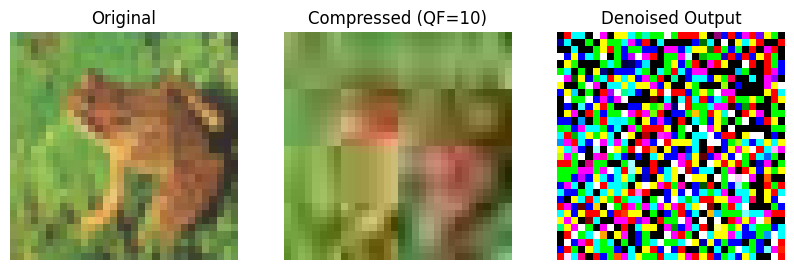

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 2: SSIM (Original vs Compressed) = 0.8552
Image 2: SSIM (Original vs Prediction) = -0.0007


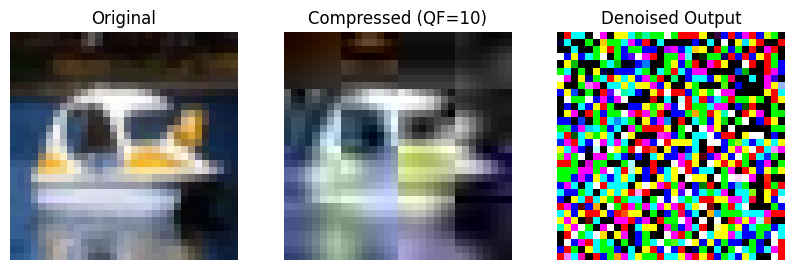

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 3: SSIM (Original vs Compressed) = 0.8396
Image 3: SSIM (Original vs Prediction) = -0.0006


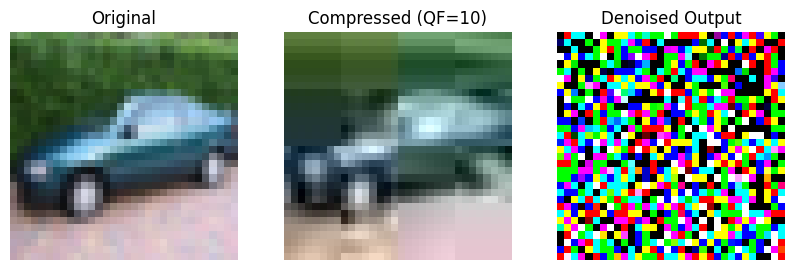

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 4: SSIM (Original vs Compressed) = 0.7465
Image 4: SSIM (Original vs Prediction) = -0.0003


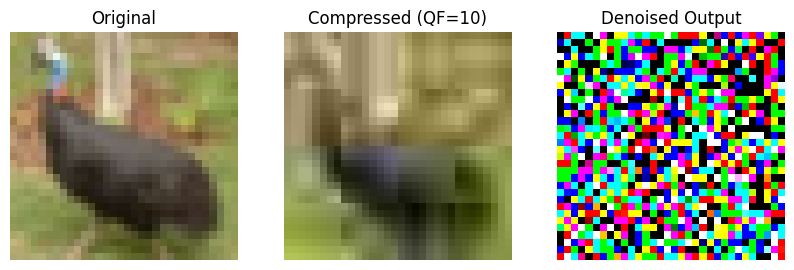

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 5: SSIM (Original vs Compressed) = 0.7696
Image 5: SSIM (Original vs Prediction) = 0.0000


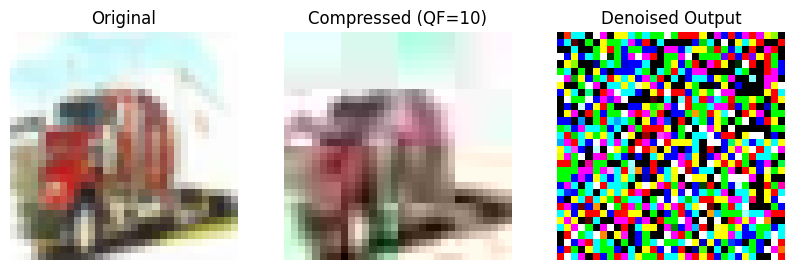

In [18]:
import torch
import torchvision
from torch.utils.data import DataLoader
from pytorch_msssim import ssim
from PIL import Image
import io
import matplotlib.pyplot as plt

# 設備設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 載入 CIFAR-10 測試集
test_dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

# 載入 MLPDenoiser 模型
class MLPDenoiser(torch.nn.Module):
    def __init__(self):
        super(MLPDenoiser, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.t_encoder = torch.nn.Linear(1, 512)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(32 * 32 * 3 + 512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 32 * 32 * 3),
            torch.nn.Tanh()
        )
    
    def forward(self, x, t):
        x = self.flatten(x)
        t = t.view(-1, 1).float()
        t_embed = self.t_encoder(t)
        x = torch.cat([x, t_embed], dim=1)
        x = self.model(x)
        x = x.view(-1, 3, 32, 32)
        return x

# 載入已訓練的模型
net = MLPDenoiser().to(device)
net.load_state_dict(torch.load("unet_denoiser.pth", map_location=device))
net.eval()

# 進行 Inference
qf = 10  # 壓縮品質 10
t_denoise = 100  # 需要去噪 90 次

with torch.no_grad():
    for idx, (img, _) in enumerate(test_dataloader):
        img = img.to(device)
        compressed_img = jpeg_compress(img, qf)
        pred_x = compressed_img.clone()

        step_t = 1
        for t in range(t_denoise, 0, -1):
            t_tensor = torch.tensor([step_t] * pred_x.shape[0]).to(device)
            estimated_noise = net(pred_x, t_tensor)
            pred_x = pred_x - estimated_noise
            step_t += 1
        
        # 計算 SSIM
        ssim_original_vs_compressed = ssim(img, compressed_img, data_range=1.0).item()
        ssim_original_vs_pred = ssim(img, pred_x, data_range=1.0).item()
        
        print(f"Image {idx + 1}: SSIM (Original vs Compressed) = {ssim_original_vs_compressed:.4f}")
        print(f"Image {idx + 1}: SSIM (Original vs Prediction) = {ssim_original_vs_pred:.4f}")
        
        # 顯示圖片
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes[0].imshow(img.squeeze().permute(1, 2, 0).cpu())
        axes[0].set_title("Original")
        axes[0].axis("off")
        
        axes[1].imshow(compressed_img.squeeze().permute(1, 2, 0).cpu())
        axes[1].set_title(f"Compressed (QF={qf})")
        axes[1].axis("off")
        
        axes[2].imshow(pred_x.squeeze().permute(1, 2, 0).cpu())
        axes[2].set_title("Denoised Output")
        axes[2].axis("off")
        
        plt.show()
        
        if idx == 4:  # 只顯示 5 張圖
            break

# DDPM的訓練pipeline

Using device: cuda
Files already downloaded and verified
Epoch 1/100, Loss: 0.05021
New best model saved!
Epoch 2/100, Loss: 0.03960
New best model saved!
Epoch 3/100, Loss: 0.04349
Epoch 4/100, Loss: 0.03941
New best model saved!
Epoch 5/100, Loss: 0.04612
Epoch 6/100, Loss: 0.05544
Epoch 7/100, Loss: 0.03713
New best model saved!
Epoch 8/100, Loss: 0.02899
New best model saved!
Epoch 9/100, Loss: 0.04535
Epoch 10/100, Loss: 0.04412
Epoch 11/100, Loss: 0.04419
Epoch 12/100, Loss: 0.06341
Epoch 13/100, Loss: 0.05235
Epoch 14/100, Loss: 0.03303
Epoch 15/100, Loss: 0.03662
Epoch 16/100, Loss: 0.02121
New best model saved!
Epoch 17/100, Loss: 0.02898
Epoch 18/100, Loss: 0.04447
Epoch 19/100, Loss: 0.03794
Epoch 20/100, Loss: 0.02693
Epoch 21/100, Loss: 0.05380
Epoch 22/100, Loss: 0.04865
Epoch 23/100, Loss: 0.05322
Epoch 24/100, Loss: 0.03883
Epoch 25/100, Loss: 0.04319
Epoch 26/100, Loss: 0.04835
Epoch 27/100, Loss: 0.03596
Epoch 28/100, Loss: 0.03574
Epoch 29/100, Loss: 0.02761
Epoch 30

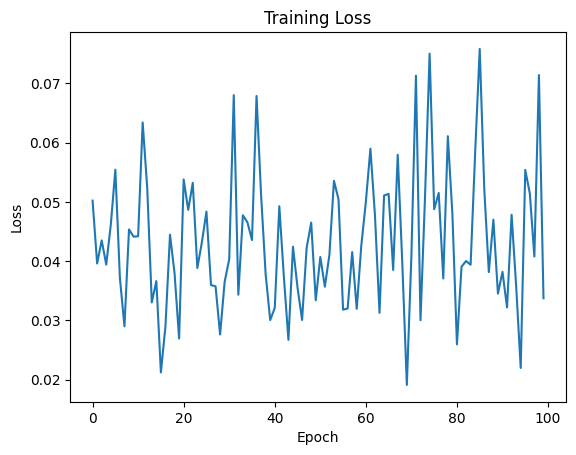

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from PIL import Image
import io
import random
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

# 設備設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 下載 CIFAR-10 資料集
dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

# 資料集拆分
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

# UNet 模型
class MLPDenoiser(torch.nn.Module):
    def __init__(self):
        super(MLPDenoiser, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.t_encoder = torch.nn.Linear(1, 512)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(32 * 32 * 3 + 512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 32 * 32 * 3),
            torch.nn.Tanh()
        )
    
    def forward(self, x, t):
        x = self.flatten(x)
        t = t.view(-1, 1).float()
        t_embed = self.t_encoder(t)
        x = torch.cat([x, t_embed], dim=1)
        x = self.model(x)
        x = x.view(-1, 3, 32, 32)
        return x

# 創建模型
net = MLPDenoiser().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100)

n_epochs = 5000
best_loss = float("inf")
loss_history = []
beta_t = torch.linspace(1e-4, 0.02, 100).to(device)
alpha_t_list = 1 - beta_t

for epoch in range(n_epochs):
    net.train()
    epoch_loss = 0
    for x0, _ in train_dataloader:
        x0 = x0.to(device)
        qf = random.randint(1, 100)  # 每個 batch 動態選擇 QF
        xt = jpeg_compress(x0, qf)
        # noise = xt - x0

        t = 101 - qf  # QF 轉換成時間步驟
        alpha_t = alpha_t_list[t - 1]  # 取對應的 alpha 值
        alpha_bar_t = torch.prod(alpha_t_list[:t])  # 計算累積的 alpha_bar

        # 計算符合 DDPM 方法的 noise
        noise = (xt - torch.sqrt(alpha_bar_t) * x0) / torch.sqrt(1 - alpha_bar_t)
        
        t_input = torch.tensor([t] * x0.shape[0]).to(device)
        predicted_noise = net(xt, t_input)
        loss = loss_fn(predicted_noise, noise)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    avg_loss = epoch_loss / len(train_dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.5f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(net.state_dict(), "best_denoiser_0319.pth")
        print("New best model saved!")

# 儲存 loss 歷史
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("loss_curve.png")
print("Loss curve saved as loss_curve.png")

# Predict noise要乘上DDPM weight

Using device: cuda
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 1: SSIM (Original vs Compressed) = 0.9028, SSIM (Original vs Denoised) = 0.9027


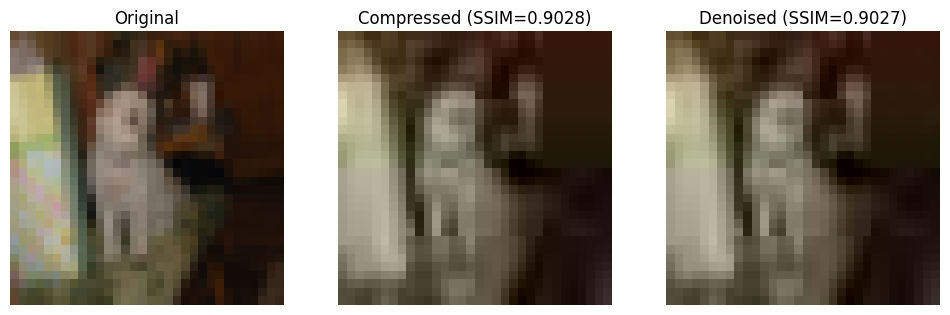

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 2: SSIM (Original vs Compressed) = 0.8645, SSIM (Original vs Denoised) = 0.8638


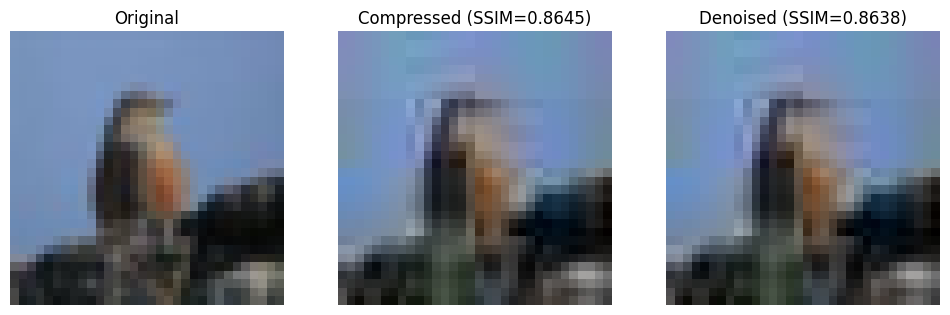

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 3: SSIM (Original vs Compressed) = 0.9404, SSIM (Original vs Denoised) = 0.9401


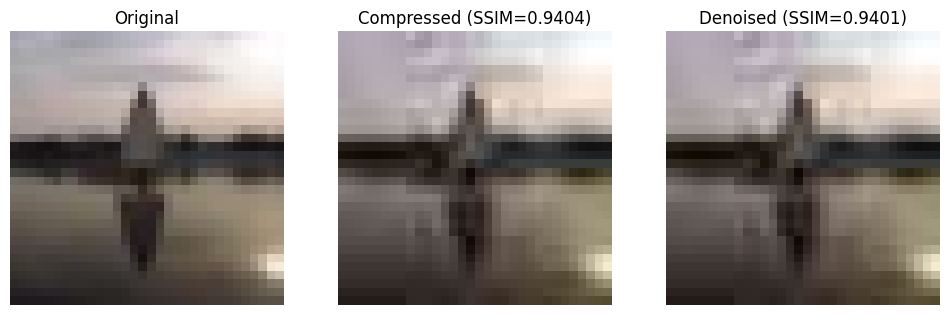

Image 4: SSIM (Original vs Compressed) = 0.8565, SSIM (Original vs Denoised) = 0.8561


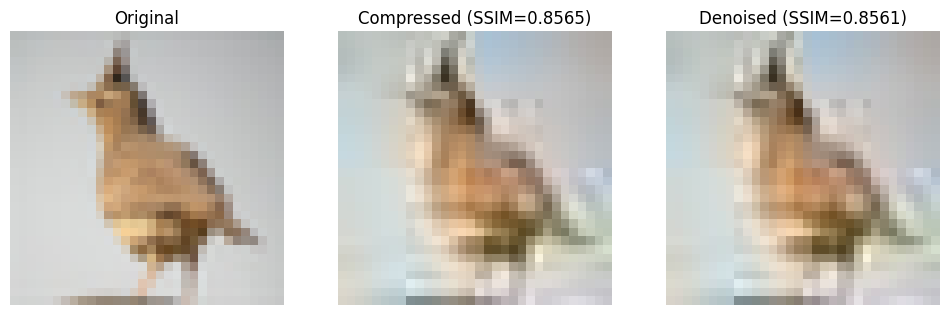

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 5: SSIM (Original vs Compressed) = 0.9167, SSIM (Original vs Denoised) = 0.9167


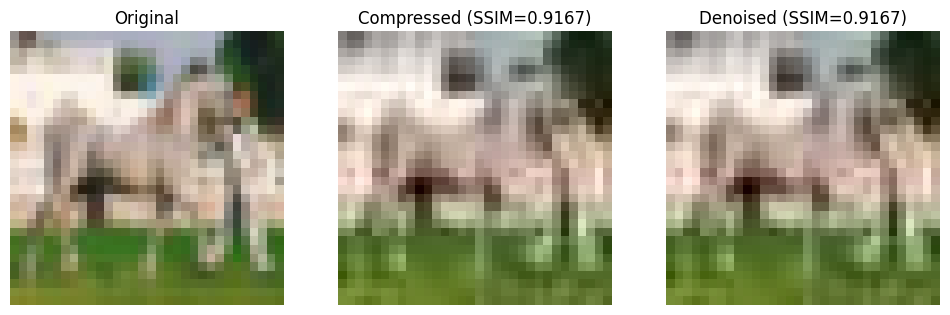

Image 6: SSIM (Original vs Compressed) = 0.8914, SSIM (Original vs Denoised) = 0.8913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


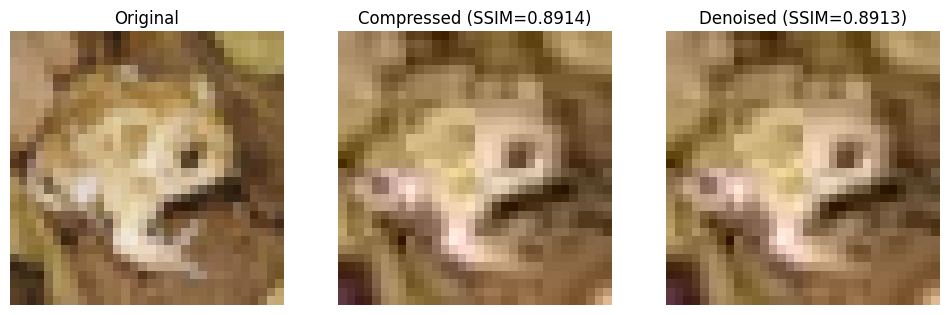

Image 7: SSIM (Original vs Compressed) = 0.8904, SSIM (Original vs Denoised) = 0.8900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


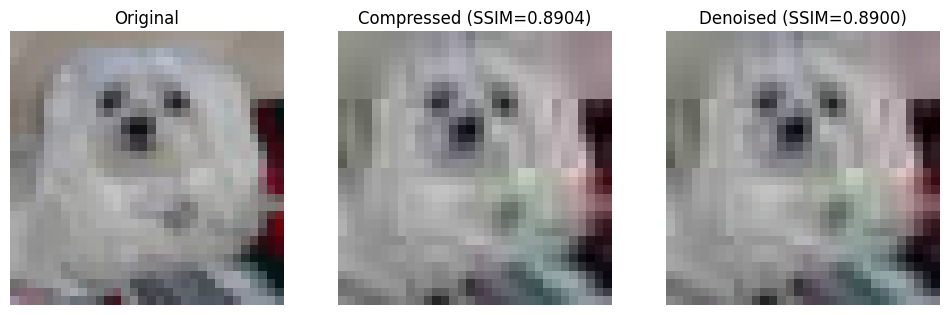

Image 8: SSIM (Original vs Compressed) = 0.8942, SSIM (Original vs Denoised) = 0.8941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


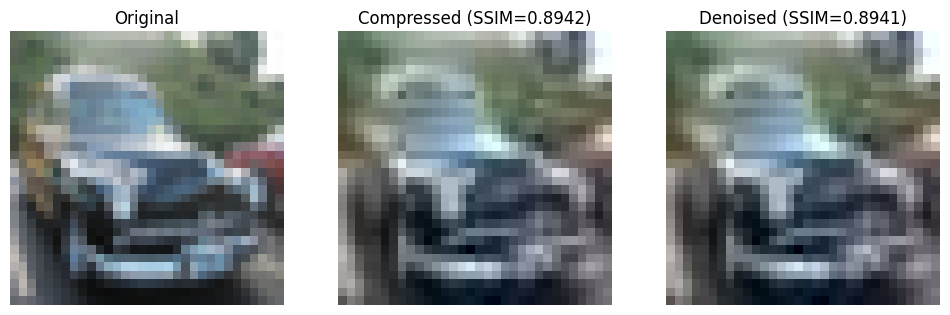

Image 9: SSIM (Original vs Compressed) = 0.8767, SSIM (Original vs Denoised) = 0.8767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


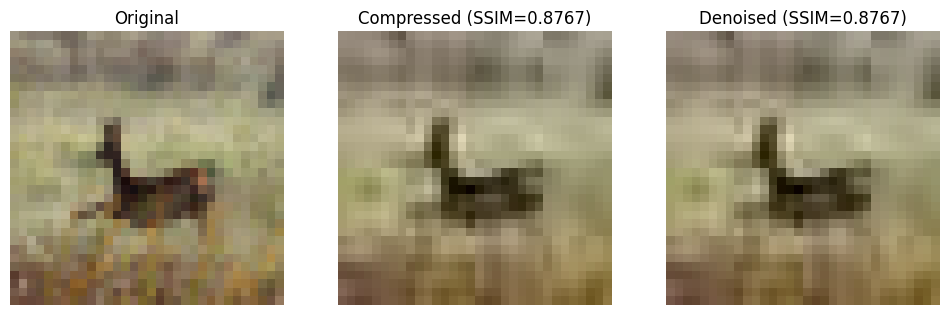

Image 10: SSIM (Original vs Compressed) = 0.9373, SSIM (Original vs Denoised) = 0.9375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


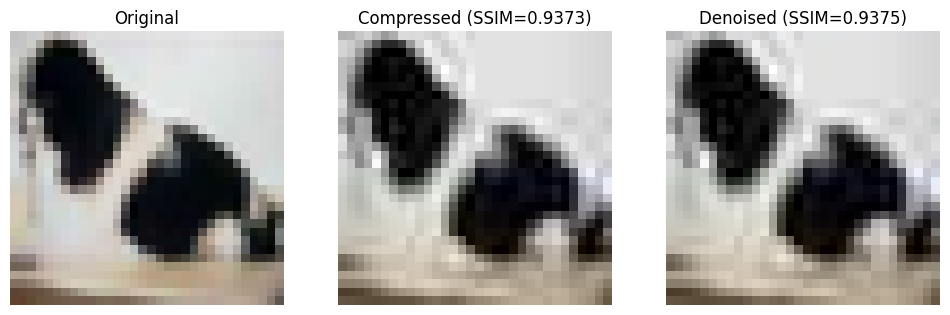

Average SSIM (Original vs Compressed): 0.8971
Average SSIM (Original vs Denoised): 0.8969


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from PIL import Image
import io
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

# 設備設置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 下載 CIFAR-10 測試資料集
dataset = torchvision.datasets.CIFAR10(
    root="cifar10/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# JPEG 壓縮函數
def jpeg_compress(x, quality):
    x = (x * 255).clamp(0, 255).byte()
    compressed_images = []
    for img in x:
        pil_img = torchvision.transforms.ToPILImage()(img)
        buffer = io.BytesIO()
        pil_img.save(buffer, format="JPEG", quality=quality)
        compressed_img = Image.open(buffer)
        compressed_images.append(torchvision.transforms.ToTensor()(compressed_img))
    return torch.stack(compressed_images).to(device)

# MLP Denoiser 模型
class MLPDenoiser(torch.nn.Module):
    def __init__(self):
        super(MLPDenoiser, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.t_encoder = torch.nn.Linear(1, 512)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(32 * 32 * 3 + 512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 32 * 32 * 3),
            torch.nn.Tanh()
        )
    
    def forward(self, x, t):
        x = self.flatten(x)
        t = t.view(-1, 1).float()
        t_embed = self.t_encoder(t)
        x = torch.cat([x, t_embed], dim=1)
        x = self.model(x)
        x = x.view(-1, 3, 32, 32)
        return x

# 加載最佳模型
net = MLPDenoiser().to(device)
net.load_state_dict(torch.load("best_denoiser_0319.pth"))
net.eval()

# 設置 DDPM 相關參數
T = 100
beta_t = torch.linspace(1e-4, 0.02, T).to(device)
alpha_t_list = 1 - beta_t

def ddpm_inference(model, x0, T=70):
    xt = jpeg_compress(x0, quality=30)
    for t in range(T, 0, -1):
        t_tensor = torch.tensor([t], device=device, dtype=torch.float32).view(1, 1)
        predicted_noise = model(xt, t_tensor)
        alpha_t = alpha_t_list[t - 1]
        alpha_bar_t = torch.prod(alpha_t_list[:t])
        xt = (1 / torch.sqrt(alpha_t)) * (xt - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise)
    return xt

# 測試與視覺化
ssim_compressed_total = 0
ssim_denoised_total = 0
num_images = 10  # 測試 10 張圖片

for i, (x0, _) in enumerate(test_dataloader):
    x0 = x0.to(device)
    x_compressed = jpeg_compress(x0, quality=30)
    x_denoised = ddpm_inference(net, x0).detach()
    
    # 計算 SSIM
    ssim_compressed = ssim(x0, x_compressed, data_range=1.0)
    ssim_denoised = ssim(x0, x_denoised, data_range=1.0)
    
    ssim_compressed_total += ssim_compressed.item()
    ssim_denoised_total += ssim_denoised.item()
    
    print(f"Image {i+1}: SSIM (Original vs Compressed) = {ssim_compressed:.4f}, SSIM (Original vs Denoised) = {ssim_denoised:.4f}")
    
    # 顯示圖片
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(x0.cpu().squeeze().permute(1, 2, 0))
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    axes[1].imshow(x_compressed.cpu().squeeze().permute(1, 2, 0))
    axes[1].set_title(f"Compressed (SSIM={ssim_compressed:.4f})")
    axes[1].axis("off")
    
    axes[2].imshow(x_denoised.cpu().squeeze().permute(1, 2, 0))
    axes[2].set_title(f"Denoised (SSIM={ssim_denoised:.4f})")
    axes[2].axis("off")
    
    plt.show()
    
    if i >= num_images - 1:
        break

# 計算平均 SSIM
avg_ssim_compressed = ssim_compressed_total / num_images
avg_ssim_denoised = ssim_denoised_total / num_images

print(f"Average SSIM (Original vs Compressed): {avg_ssim_compressed:.4f}")
print(f"Average SSIM (Original vs Denoised): {avg_ssim_denoised:.4f}")